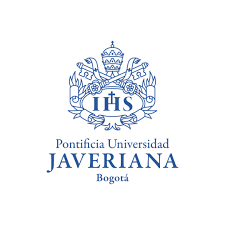
***Pontificia Universidad Javeriana***
# **Procesamiento de Alto Volumen de Datos**

### Taller: **Métricas de Rendimiento para Modelos de Clasificación con PySpark**

Autor: Federico Quiroga

Fecha: 19/05/2025

**Objetivo**: Evaluar modelo de clasificación MLlib

- La clasificación se utiliza para clasificar datos en etiquetas o clases predefinidas. Para evaluar el rendimiento de un modelo de clasificación se suelen utilizar métricas como: accuracy, precision, recall, F1 score y la matriz de confusión. Estas métricas son útiles para evaluar lo bien que el modelo distingue entre clases, especialmente en casos de conjuntos de datos desequilibrados. Al conocer los puntos fuertes y débiles de cada métrica, se podrá seleccionar la más adecuada para un problema de clasificación determinado.

- MLlib de PySpark, se presenta un conjunto de clases: BinaryClassificationEvaluator, MulticlassificationEvaluator, y RegressionEvaluator-diseñadas para evaluar el rendimiento de los modelos de aprendizaje automático calculando métricas específicas a partir de predicciones y etiquetas verdaderas. Se utilizan para evaluar modelos entrenados con estimadores como RandomForestClassifier o GBTRegressor, tomando un DataFrame con valores predichos y reales para producir una única puntuación de rendimiento. Ejecutados a través de una SparkSession, aprovechan los ejecutores de Spark para la computación distribuida, lo que los hace ideales para **BIG DATA** de fuentes como archivos CSV o Parquet. Se integran en herramientas de ajuste como CrossValidator y TrainValidationSplit, ofreciendo una solución escalable para la evaluación de modelos.
____________________________________________________

### Introducción


ión

Este taller tiene como objetivo desarrollar un **modelo predictivo sólido** que permita determinar la probabilidad de que una persona presente una enfermedad cardíaca, a partir de diversas variables relacionadas con su estado de salud.

El proceso abarca todas las etapas clave de un proyecto de ciencia de datos: desde el análisis exploratorio, pasando por la limpieza y transformación de los datos, hasta la construcción y evaluación del modelo. Cada una de estas fases se presenta con explicaciones detalladas, haciendo énfasis en los pasos más relevantes para la toma de decisiones.

Además de construir el modelo, se incluye un análisis crítico de su desempeño mediante métricas de evaluación adecuadas, lo que permite reflexionar sobre su utilidad práctica y posibles mejoras.

### Setup notebook

**1.- Crear sessión PySpark**



```
from pyspark.sql.functions import col, when, avg
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Taller_Metricas").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Ejcución de las tareas en ", cores, "core(s) del sistema de cómputo actual")
spark
```



In [ ]:
# Se importan las funciones de sql necesarias para transformar el dataset.
from pyspark.sql.functions import col, when, avg, count, isnan, isnull
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Taller_Metricas").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("Ejcución de las tareas en ", cores, "core(s) del sistema de cómputo actual")
spark

Ejcución de las tareas en  1 core(s) del sistema de cómputo actual


**2.-Cargar DataFrame Spark:**
- Enlace de datos: https://github.com/corredor-john/ExploratoryDataAnalisys/blob/main/Varios/heart_taller_eval_PySpark.csv

```
from pyspark import SparkFiles
url_github = "Enlace de datos"

spark.sparkContext.addFile(url_github)
df00 = spark.read.csv(SparkFiles.get("fichero.csv"),inferSchema=True, header=True)
df00.show(5)
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Ruta al archivo CSV en Google Drive
HeartD_File_path = "/content/drive/MyDrive/Colab Notebooks/EXTRA/Prosesamiento datos Datasets/Heart_disease.csv"

df00 = spark.read.csv(HeartD_File_path, header=True, inferSchema=True)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|

### Analisis exploratorio

In [ ]:
# Muestra las primeras filas del DataFrame
df00.show(5)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

Descripión de variables:

1. **Age**: Edad del paciente, expresada en años.

2. **Sex**: Sexo biológico del paciente. Se representa como:
   - 'M' para masculino.
   - 'F' para femenino.

3. **ChestPainType**: Tipo de dolor en el pecho reportado. Categorías:
   - 'ATA' (Angina típica)
   - 'NAP' (Angina atípica)
   - 'ASY' (Asintomático)
   - 'TA' (Dolor no anginoso)

4. **RestingBP**: Presión arterial en reposo del paciente (en mm Hg) tomada al momento de la consulta.

5. **Cholesterol**: Nivel de colesterol sérico en mg/dl.

6. **FastingBS**: Nivel de azúcar en sangre en ayunas. Se codifica como:
   - 1 si es mayor a 120 mg/dl.
   - 0 en caso contrario.

7. **RestingECG**: Resultados del electrocardiograma en reposo. Valores posibles:
   - 'Normal'
   - 'ST' (Anomalías en la onda ST-T)
   - 'LVH' (Hipertrofia ventricular izquierda)

8. **MaxHR**: Frecuencia cardiaca máxima alcanzada durante el ejercicio.

9. **ExerciseAngina**: Angina inducida por ejercicio. Codificada como:
   - 'Y' para Sí.
   - 'N' para No.

10. **Oldpeak**: Depresión del segmento ST medida durante el esfuerzo, en relación con el reposo. Cuantifica la desviación del ST en unidades.

11. **ST_Slope**: Pendiente del segmento ST durante el ejercicio. Categorías:
    - 'Up' (ascendente)
    - 'Flat' (plana)
    - 'Down' (descendente)

12. **HeartDisease**: Variable objetivo. Indica la presencia de enfermedad cardíaca:
    - 1 para diagnóstico positivo de enfermedad cardíaca.
    - 0 en caso contrario.


**3.- Revisión de Datos Nulos o Imposibles:**


```
from pyspark.sql.functions import *

df3.select([count(when(col(c).contains('None') |
col(c).contains('NULL') |
(col(c) == '' ) |
col(c).isNull() | isnan(c), c )).alias(c)
for c in df34.columns]).show()
)
```

In [ ]:
df00.select([count(when(col(c).contains('None') |
col(c).contains('NULL') |
(col(c) == '' ) |
col(c).isNull() | isnan(c), c )).alias(c)
for c in df00.columns]).show()


+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|  0|  0|            0|        0|          0|        0|         0|    0|             0|      0|       0|           0|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+



Como se observa en la tabla, no se encontraron valores nulos, vacíos ni inválidos en ninguna de las columnas del dataset. Por lo tanto, no es necesario realizar procesos adicionales de limpieza relacionados con datos faltantes.

**4.- Relación entre las variables**
- Escriba algunas apreciaciones de las relaciones


```
import matplotlib
import seaborn

plt.figure(figsize =(X,x))
vista_pandas = df6.toPandas()
sns.heatmap(vista_pandas.select_dtypes(np.number).corr(), annot=True, center=0, cmap ='RdYlGn')
```

<Axes: >

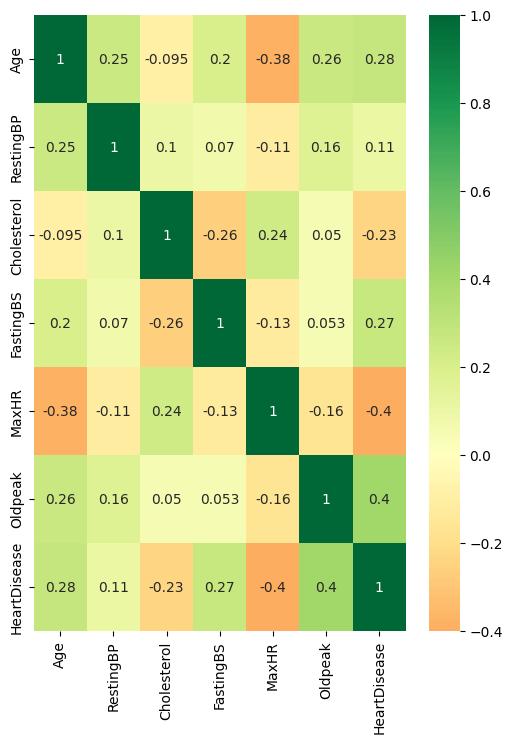

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.figure(figsize =(6,8))
vista_pandas = df00.toPandas()
sns.heatmap(vista_pandas.select_dtypes(np.number).corr(), annot=True, center=0, cmap ='RdYlGn')

Se uso la matriz de correlación entre las variables numéricas del dataset para entender la relación entre las mismas.

Este tipo de graficas permiten identificar la intensidad y dirección de las relaciones lineales entre pares de variables. Valores cercanos a 1 indican una correlación positiva fuerte, mientras que valores cercanos a -1 indican una correlación negativa fuerte.

Se observa que:
- La variable `HeartDisease` presenta una correlación negativa moderada con `MaxHR` (-0.40) y positiva moderada con `Oldpeak` (0.40), lo que podría indicar que una frecuencia cardiaca máxima más baja y un mayor nivel de depresión del ST están asociados con la presencia de enfermedad cardíaca.
- `Age` también muestra correlaciones positivas débiles con `Oldpeak` (0.26) y `HeartDisease` (0.28), lo que sugiere una ligera tendencia de aumento en el riesgo cardíaco con la edad.
- La mayoría de las demás correlaciones entre variables son débiles o muy bajas, lo que indica una baja colinealidad general entre los predictores.


### Ingeniería de características

**5.- Consulte los tipos de datos**



```
dfBog.dtypes
```

In [ ]:
df00.show(5)

+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
|Age|Sex|ChestPainType|RestingBP|Cholesterol|FastingBS|RestingECG|MaxHR|ExerciseAngina|Oldpeak|ST_Slope|HeartDisease|
+---+---+-------------+---------+-----------+---------+----------+-----+--------------+-------+--------+------------+
| 40|  M|          ATA|      140|        289|        0|    Normal|  172|             N|    0.0|      Up|           0|
| 49|  F|          NAP|      160|        180|        0|    Normal|  156|             N|    1.0|    Flat|           1|
| 37|  M|          ATA|      130|        283|        0|        ST|   98|             N|    0.0|      Up|           0|
| 48|  F|          ASY|      138|        214|        0|    Normal|  108|             Y|    1.5|    Flat|           1|
| 54|  M|          NAP|      150|        195|        0|    Normal|  122|             N|    0.0|      Up|           0|
+---+---+-------------+---------+-----------+---------+-

In [ ]:
df00.dtypes

[('Age', 'int'),
 ('Sex', 'string'),
 ('ChestPainType', 'string'),
 ('RestingBP', 'int'),
 ('Cholesterol', 'int'),
 ('FastingBS', 'int'),
 ('RestingECG', 'string'),
 ('MaxHR', 'int'),
 ('ExerciseAngina', 'string'),
 ('Oldpeak', 'double'),
 ('ST_Slope', 'string'),
 ('HeartDisease', 'int')]

**6.- Funciones para datos ETIQUETAS o categorías a Numéricos**
- 6.1: Imprimir todas las columnas de Etiquetas del tipo string


```
dataframe.select('Columna_Str_A').distinct().show()
dataframe.select('Columna_Str_H').distinct().show()
```



In [ ]:
df00.select('Sex').distinct().show()
df00.select('ChestPainType').distinct().show()
df00.select('ExerciseAngina').distinct().show()
df00.select('RestingECG').distinct().show()
df00.select('ST_Slope').distinct().show()

+---+
|Sex|
+---+
|  F|
|  M|
+---+

+-------------+
|ChestPainType|
+-------------+
|          NAP|
|          ATA|
|           TA|
|          ASY|
+-------------+

+--------------+
|ExerciseAngina|
+--------------+
|             Y|
|             N|
+--------------+

+----------+
|RestingECG|
+----------+
|       LVH|
|    Normal|
|        ST|
+----------+

+--------+
|ST_Slope|
+--------+
|    Flat|
|      Up|
|    Down|
+--------+



- 6.2: Usar la función para cambiar a dato numéricos

```
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

def fun_Etiquetas(df):
    trans_df = df.select("*",(when(df.ExerciseAngina=='Y', 1).otherwise(0)).alias('yes_exercise_angina')
                 ,(when(df.ChestPainType=='ATA', 1).otherwise(0)).alias('ata_chest_pain_type')
              ,(when(df.ChestPainType=='ASY', 1).otherwise(0)).alias('asy_chest_pain_type')
              ,(when(df.ST_Slope=='Up', 1).otherwise(0)).alias('up_st_slope')
              ,(when(df.Sex=='F', 1).otherwise(0)).alias('f_sex')
              ,(when(df.RestingECG=='ST', 1).otherwise(0)).alias('st_resting_ecg')
                 )
        .drop('ExerciseAngina','ChestPainType', 'ST_Slope', 'Sex', 'RestingECG')
        .withColumnRenamed("HeartDisease", 'label')

features_list = trans_df.columns
print(features_list)
features_list.remove('label')
assembler = VectorAssembler(inputCols=features_list,outputCol='features')
vector_trans_df = assembler.transform(trans_df).select('features','label')
    
return vector_trans_df, trans_df


vector_trans_df, trans_df = fun_Etiquetas(dataframes)
```

In [ ]:
# Importación de tipos de datos y transformadores de PySpark
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

# Función que transforma variables categóricas a variables dummy (0/1) y crea un vector de características
def fun_Etiquetas(df):
    # Crear nuevas columnas binarias a partir de variables categóricas
    trans_df = df.select("*",
                 (when(df.ExerciseAngina == 'Y', 1).otherwise(0)).alias('yes_exercise_angina'),  # 1 si hay angina inducida por ejercicio
                 (when(df.ChestPainType == 'ATA', 1).otherwise(0)).alias('ata_chest_pain_type'),  # 1 si el tipo de dolor es angina típica
                 (when(df.ChestPainType == 'ASY', 1).otherwise(0)).alias('asy_chest_pain_type'),  # 1 si el tipo de dolor es asintomático
                 (when(df.ST_Slope == 'Up', 1).otherwise(0)).alias('up_st_slope'),                # 1 si la pendiente ST es ascendente
                 (when(df.Sex == 'F', 1).otherwise(0)).alias('f_sex'),                            # 1 si el sexo es femenino
                 (when(df.RestingECG == 'ST', 1).otherwise(0)).alias('st_resting_ecg')           # 1 si el ECG muestra anormalidad ST
             )\
        .drop('ExerciseAngina','ChestPainType', 'ST_Slope', 'Sex', 'RestingECG').withColumnRenamed("HeartDisease", 'label')  # Renombrar la variable objetivo a 'label' para usarla en ML

    # Obtener todas las columnas como lista
    features_list = trans_df.columns
    print(features_list)

    # Eliminar la columna de salida (label) de la lista de características
    features_list.remove('label')

    # Crear una columna vector con todas las características para usar en modelos
    assembler = VectorAssembler(inputCols=features_list, outputCol='features')

    # Transformar el dataframe con la nueva columna 'features' y conservar solo 'features' y 'label'
    vector_trans_df = assembler.transform(trans_df).select('features', 'label')

    # Retornar el dataframe vectorizado y el transformado original
    return vector_trans_df, trans_df

# Llamar la función usando el dataframe original 'dataframes'
vector_trans_df, trans_df = fun_Etiquetas(df00)


['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'label', 'yes_exercise_angina', 'ata_chest_pain_type', 'asy_chest_pain_type', 'up_st_slope', 'f_sex', 'st_resting_ecg']


6.3.- Imprimir 5 primeros valores de la transformación a vectores

```
vector_trans_df.show(n, False)

```

In [ ]:
vector_trans_df.show(5,False)

+--------------------------------------------------------+-----+
|features                                                |label|
+--------------------------------------------------------+-----+
|(12,[0,1,2,4,7,9],[40.0,140.0,289.0,172.0,1.0,1.0])     |0    |
|(12,[0,1,2,4,5,10],[49.0,160.0,180.0,156.0,1.0,1.0])    |1    |
|[37.0,130.0,283.0,0.0,98.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0] |0    |
|[48.0,138.0,214.0,0.0,108.0,1.5,1.0,0.0,1.0,0.0,1.0,0.0]|1    |
|(12,[0,1,2,4,9],[54.0,150.0,195.0,122.0,1.0])           |0    |
+--------------------------------------------------------+-----+
only showing top 5 rows



Además de transformar las variables categóricas a formato numérico (mediante codificación binaria), el DataFrame se organiza en vectores que agrupan todas las características relevantes en una única columna llamada features.

Esta transformación es esencial para preparar los datos antes de ser utilizados en modelos de aprendizaje automático, ya que estos requieren que las variables predictoras estén representadas como vectores numéricos.

La columna label, por su parte, contiene la variable objetivo que indica si el paciente presenta o no enfermedad cardíaca.

**7.- División de Datos Entrenamiento y Prueba**


```
entrenamiento, prueba = vector_trans_df.randomSplit([0.7,0.3], seed = 13)

```

In [ ]:
entrenamiento, prueba = vector_trans_df.randomSplit([0.7,0.3], seed = 13)

**8.- Consulta: Escriba sus apreciaciones sobre el balanceo de los datos, en Entrenamiento y en los de Prueba**



```
total=float(entrenamiento.select("label").count())
Positivos=entrenamiento.select("label").where('label == 1').count()
porcentaje=(float(Positivos)/float(total))*100
Negativos=float(total-Negativos)
print('Cantidad de positivos {}'.format(Positivos))
print('Percentaje de positivos {}'.format(porcentaje))

```

In [ ]:
total=float(entrenamiento.select("label").count())
Positivos=entrenamiento.select("label").where('label == 1').count()
porcentaje=(float(Positivos)/float(total))*100
Negativos=float(total-Positivos)
print('Cantidad de positivos {}'.format(Positivos))
print('Percentaje de positivos {}'.format(porcentaje))

Cantidad de positivos 359
Percentaje de positivos 53.9039039039039


Para los datos de entrenamiento se observa que existen **359 registros positivos**, lo que representa aproximadamente el **53.9% del total**. Esto indica que el conjunto de entrenamiento está **moderadamente balanceado**, ya que ambas clases tienen una representación similar. Esto es ideal para evitar que el modelo se sesgue hacia la clase mayoritaria.

In [ ]:
total_test = float(prueba.select("label").count())
positivos_test = prueba.select("label").where('label == 1').count()
porcentaje_test = (float(positivos_test) / float(total_test)) * 100
negativos_test = float(total_test - positivos_test)

print('Cantidad de positivos en prueba: {}'.format(positivos_test))
print('Porcentaje de positivos en prueba: {:.2f}%'.format(porcentaje_test))

Cantidad de positivos en prueba: 149
Porcentaje de positivos en prueba: 59.13%


Para los datos de prueba se observa que existen** 149 observaciones positivas**, lo que representa aproximadamente el **59.13% del total**.

Este porcentaje indica que la clase positiva tiene una ligera mayoría dentro del conjunto de prueba. Aunque el desbalance no es extremo, es importante tenerlo en cuenta al evaluar métricas como precisión, recall y F1-score, ya que un sesgo en la distribución de clases puede influir en el comportamiento del modelo.

## Modelado

**9.- Modelo a seguir es de árboles de decisiones**

```
from pyspark.ml.classification import DecisionTreeClassifier

parametros = {'maxDepth':4}

clasificador = DecisionTreeClassifier(**parametros, seed= 13)
clasificador

modeloArboles = clasificador.fit(trainset)

```



In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

parametros = {'maxDepth':4}

clasificador = DecisionTreeClassifier(**parametros, seed= 13)
clasificador

modeloArboles = clasificador.fit(entrenamiento)

**10.- Predicciones sobre los datos de prueba**

```
prediccionesPrueba = clasificador.transform(valoresPruebas)
prediccionesPrueba.show(2, False)

```

In [ ]:
prediccionesPrueba = modeloArboles.transform(prueba)
prediccionesPrueba.show(5, False)

+---------------------------------------------------+-----+-------------+----------------------------------------+----------+
|features                                           |label|rawPrediction|probability                             |prediction|
+---------------------------------------------------+-----+-------------+----------------------------------------+----------+
|(12,[0,1,2,3,4],[74.0,140.0,237.0,1.0,94.0])       |1    |[9.0,36.0]   |[0.2,0.8]                               |1.0       |
|(12,[0,1,2,3,4,5],[52.0,152.0,298.0,1.0,178.0,1.2])|0    |[6.0,15.0]   |[0.2857142857142857,0.7142857142857143] |1.0       |
|(12,[0,1,2,3,4,8],[64.0,130.0,258.0,1.0,130.0,1.0])|1    |[13.0,221.0] |[0.05555555555555555,0.9444444444444444]|1.0       |
|(12,[0,1,2,4],[53.0,145.0,518.0,130.0])            |1    |[9.0,36.0]   |[0.2,0.8]                               |1.0       |
|(12,[0,1,2,4],[55.0,140.0,295.0,136.0])            |1    |[9.0,36.0]   |[0.2,0.8]                               |1.0 

##**11.- Evaluación de Modelo de Clasificación**

- Presente la matriz de confusión y de sus apreciaciones
- Reto pinte ROC y obtenga el valor AUC y de sus apreciaciones

```
matrzC_prueba = predictionAndLabels.crosstab("prediction", "label")
matrzC_prueba = matrzC_prueba.toPandas()
matrzC_prueba.sort_values(by = ['prediction_label'])
```


In [ ]:
predictionAndLabels = prediccionesPrueba.select("prediction", "label")
matrzC_prueba = predictionAndLabels.crosstab("prediction", "label")
matrzC_prueba = matrzC_prueba.toPandas()
matrzC_prueba.sort_values(by = ['prediction_label'])

,prediction_label,0,1
1,0.0,82,27
0,1.0,21,122


- **Verdaderos Positivos (TP = 82):** Casos correctamente clasificados como personas con enfermedad cardíaca.
- **Verdaderos Negativos (TN = 122):** Casos correctamente identificados como sanos.
- **Falsos Positivos (FP = 27):** Casos que fueron clasificados como enfermos, pero en realidad no lo estaban.
- **Falsos Negativos (FN = 21):** Casos en los que el modelo no logró detectar la enfermedad, aunque sí estaba presente.

El modelo presenta un buen comportamiento general, logrando clasificar correctamente la mayoría de los casos. Sin embargo, los **falsos negativos** son particularmente relevantes en contextos médicos, ya que representan pacientes enfermos no detectados. Para minimizar el riesgo para los pacientes, es pertinente la **sensibilidad (recall)** del modelo, aunque esto implique un pequeño aumento en falsos positivos.

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Extraer la columna 'probability' y el 'label'
# Se requiere una RDD de pares (score, label)
scoreAndLabels = prediccionesPrueba.select("probability", "label") \
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))

# Crear objeto para evaluación binaria
metrics = BinaryClassificationMetrics(scoreAndLabels)

# Obtener AUC
auc = metrics.areaUnderROC
print(f" Área bajo la curva ROC (AUC): {auc:.4f}")


/usr/local/lib/python3.11/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


🔍 Área bajo la curva ROC (AUC): 0.8700


El modelo obtuvo un valor de **AUC = 0.87** al ser evaluado sobre el conjunto de prueba. Este resultado indica un **alto poder discriminativo**, es decir, el modelo tiene una muy buena capacidad para distinguir entre pacientes con y sin enfermedad cardíaca.

Un AUC de 0.87 significa que, ante un par aleatorio de casos (uno positivo y uno negativo), el modelo tiene un 87% de probabilidad de asignar una mayor puntuación al caso positivo. En el contexto clínico, donde es fundamental minimizar errores en el diagnóstico, este valor es especialmente alentador, ya que sugiere que el modelo está tomando decisiones acertadas en la mayoría de los casos.



- Imprima las métricas a continuación en (0.00%), escriba sus apreciaciones

```
TP = cm_pruebas["1"][0]
FP = cm_pruebas["0"][0]
TN = cm_pruebs["0"][1]
FN = cm_pruba["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)


print(f"Metrica = {np.round(Metrica,n)*100}%")

```

In [ ]:
TP = matrzC_prueba["1"][0]
FP = matrzC_prueba["0"][0]
TN = matrzC_prueba["0"][1]
FN = matrzC_prueba["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)


print(f"Metrica = {np.round(Accuracy,2)*100}%")
print(f"Metrica = {np.round(Sensitivity,2)*100}%")
print(f"Metrica = {np.round(Specificity,2)*100}%")
print(f"Metrica = {np.round(Precision,2)*100}%")

Metrica = 81.0%
Metrica = 82.0%
Metrica = 80.0%
Metrica = 85.0%


A partir de la matriz de confusión y las predicciones realizadas sobre el conjunto de prueba, se calcularon las siguientes métricas:

- **Accuracy (Exactitud): 81.0%**  
  El modelo clasifica correctamente el 81% del total de casos. Esta métrica global considera tanto verdaderos positivos como verdaderos negativos.

- **Sensitivity (Recall o Tasa de verdaderos positivos): 82.0%**  
  Indica que el modelo detecta correctamente el 82% de los casos positivos (pacientes con enfermedad cardíaca). Es una métrica clave en contextos clínicos.

- **Specificity (Tasa de verdaderos negativos): 80.0%**  
  El modelo identifica correctamente el 80% de los casos negativos (pacientes sanos), lo que reduce falsos diagnósticos.

- **Precision (Precisión): 85.0%**  
  De todas las predicciones positivas realizadas, el 85% corresponde efectivamente a pacientes con enfermedad. Es una medida de confianza en las predicciones positivas.

En conjunto, estas métricas reflejan un modelo balanceado, con buena capacidad para distinguir entre pacientes con y sin enfermedad cardíaca, manteniendo controlados tanto los falsos positivos como los falsos negativos.

**12.- Terminar sesión SPARK**

```
spark.stop()
```

In [ ]:
spark.stop()

## **12.- Conclusiones

Dentro del proceso de análisis de datos, cada etapa de un proyecto de ciencia de datos cumple un rol fundamental. Desde el análisis exploratorio inicial, donde se comprenden las características y tipos de datos disponibles, hasta la limpieza y preparación de los mismos, que garantiza la calidad y confiabilidad de la información utilizada.

El uso de herramientas como PySpark y entornos como Google Colab facilita la ejecución eficiente de estas tareas sobre grandes volúmenes de datos, permitiendo automatizar procesos y acelerar los tiempos de desarrollo.

Sin embargo, más allá de la preparación de los datos, la etapa más crítica es la evaluación e interpretación del modelo. Escoger las métricas adecuadas, analizarlas correctamente y comprender sus implicaciones es lo que finalmente permite mejorar el desempeño del modelo y tomar decisiones sólidas basadas en sus resultados. Esta capacidad de análisis es la que convierte un modelo en una herramienta útil y aplicable en contextos reales.